# Convolutional Layers and Convolutional Networks: A Quick Primer

Convolutional Neural Networks (CNNs) are neural networks where some (many) of the layers perform **convolutions** instead of matrix multiplication (as in a linear (aka fully-connected) layer. Please watch (I'd recommend at greater than 1x speed) the following videos to get a basic introduction to convolutional layers and convolutional networks.

After watching these videos, you should:
* Understand the differences between a standard convolution layer in a convolutional neural network and the traditional 2D image processing convolution we've discussed thus far:
    * It's technically cross-correlation instead of convolution (why bother flipping the kernel if the weights are learned?)
    * There are Separate weights per channel
    * Each filter sums across channels, and produces a single channel of the output feature map
* Know the meaning of a few of the variations possible with convolution layers:
    * Stride (where the window slides by more than 1 pixel at a time)
    * Bias (where a separate scalar parameter is added to the filter's output channel, similar to a bias in a linear layer)
 
Here are the videos:
* C4W1L06 - Convolutions Over Volumes https://www.youtube.com/watch?v=KTB_OFoAQcc
* C4W1L07 - One Layer of a Convolutional Net https://www.youtube.com/watch?v=jPOAS7uCODQ
* C4W1L08 - Simple Convolutional Network Example https://www.youtube.com/watch?v=3PyJA9AfwSk, but don't get bogged down in the notation details.
* If you want to see a friendly introduction to Max Pooling layers, also check out this one: C4W1L09 Pooling Layers https://www.youtube.com/watch?v=8oOgPUO-TBY

# CNN Architecture By Example: LeNet on the MNIST
Now, we'll use this notebook to explore the use of CNNs on a "small" dataset of handwritten digits. 

By the end of this activity, you should be able to:
* Know some of the typical architectural features of CNNs

An early success case for CNNs was a network called LeNet (after Yann **Le**Cun), which performed well on a dataset of handwritten digits called MNIST.

In this notebook you will experiment with different architectures on the MNIST dataset to get a feel for how CNNs work. With modern techniques and compute, this dataset is considered a toy dataset, but it's still an interesting testing ground for architecture ideas. In particular, we're going to look at it through the lens of how many **parameters** we need to learn to do well on the dataset.

### You'll Need a GPU

To train the models in this notebook, you'll want to be on a machine with an NVIDIA GPU. Please see the [Project 4 instructions](https://facultyweb.cs.wwu.edu/~wehrwes/courses/csci476_24w/p4/#hardware) for details on how to do this.

#### Useful functions

Run the below cell to define functions that will be used later

In [5]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable

import urllib
import cv2
import numpy as np
import os, sys,  math, random, subprocess
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output, Image, display, HTML
from io import StringIO
import PIL.Image

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)
    
import ML

def get_n_params(module):
  nparam = 0
  for name, param in module.named_parameters():
    param_count = 1
    for size in list(param.size()):
      param_count *= size
    nparam += param_count
  return nparam

def get_model_params(model):
  nparam = 0
  for name, module in model.named_modules():
    nparam += get_n_params(module)
  return nparam

def to_numpy_image(tensor_or_variable):
  
  # If this is already a numpy image, just return it
  if type(tensor_or_variable) == np.ndarray:
    return tensor_or_variable
  
  # Make sure this is a tensor and not a variable
  if type(tensor_or_variable) == Variable:
    tensor = tensor_or_variable.data
  else:
    tensor = tensor_or_variable
  
  # Convert to numpy and move to CPU if necessary
  np_img = tensor.cpu().numpy()
  
  # If there is no batch dimension, add one
  if len(np_img.shape) == 3:
    np_img = np_img[np.newaxis, ...]
  
  # Convert from BxCxHxW (PyTorch convention) to BxHxWxC (OpenCV/numpy convention)
  np_img = np_img.transpose(0, 2, 3, 1)
  
  return np_img

def normalize_zero_one_range(tensor_like):
  x = tensor_like - tensor_like.min()
  x = x / (x.max() + 1e-9)
  return x

def prep_for_showing(image):
  np_img = to_numpy_image(image)
  if len(np_img.shape) > 3:
    np_img = np_img[0]
  np_img = normalize_zero_one_range(np_img)
  return np_img

def show_image(tensor_var_or_np, title=None, bordercolor=None):
  np_img = prep_for_showing(tensor_var_or_np)
  
  if bordercolor is not None:
    np_img = draw_border(np_img, bordercolor)
  
  # plot it
  np_img = np_img.squeeze()
  plt.figure(figsize=(4,4))
  plt.imshow(np_img)
  plt.axis('off')
  if title: plt.title(title)
  plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Training Data

We will use the [MNIST handrwritten digit dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) to train our neural network models. There is a simple wrapper for the MNIST dataset in the torchvision package that implements the Dataset class. We will use that in conjunction with the DataLoader to load training data. Run the below cell to download and initialize our training and test datasets. You should see an example batch of images and their labels shown.

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
show_image(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(BATCH_SIZE)))

Each image has 1 channel (note the channel dimension is before the spatial dimensions), is 28x28 pixels, and our `images` tensor here has a batch of 32 of them:

In [ ]:
print(images.shape)

## Example CNN Architecture

Here's a diagram of the LeNet architecture:
![](../data/lenet.png)

Below is an example model provided to you. This architecture is similar, though not identical to the original LeNet architecture depicted above. It is pretty good and it reaches >98% accuracy on the test set, although better accuracy is quite possible.

A few important things to notice about this architecture that are typical of CNN architectures:
* The network begins by alternating between:
    * conv layers, which keep the spatial dimensions mostly the same, except for the few pixels lost to "valid" output size
    * Some layer which reduces the spatial resolution.
* As the spatial dimensions get smaller, the channel (number of filters, or feature map depth) gets larger
* At some point, we start ignoring the spatial dimensions (conceptually "unrolling the (h x w x c) feature map into a 1D vector of length (h*w*c), then apply some linear (fully-connected) layers.
* In this case, the layer that halves the spatial resolution is a 2x2 [max pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layer with stride 2, meaning it takes the max value in every (non-overlapping) 2x2 block of pixels.

In [ ]:
class ExampleModel(nn.Module):
    def __init__(self):
        super(ExampleModel, self).__init__()
        # Convolution. Input channels: 1, output channels: 6, kernel size: 5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # Max-pooling layer that will halve the HxW resolution
        self.pool = nn.MaxPool2d(2, 2)
        # Another 5x5 convolution that brings channel count up to 16
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Three fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 60)
        self.fc2 = nn.Linear(60, 40)
        self.fc3 = nn.Linear(40, 10)

    def forward(self, x):
        # Apply convolution, activation and pooling
        # Output width after convolution = (input_width - (kernel_size - 1) / 2)
        # Output width after pooling = input_width / 2
        
        # x.size() = Bx1x28x28
        x = self.pool(F.relu(self.conv1(x)))
        # x.size() = Bx6x12x12
        x = self.pool(F.relu(self.conv2(x)))
        # x.size() = Bx16x4x4
        
        # Flatten the output
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


example_cnn = ExampleModel()

#### Parameter Counting

In this exploration, we're going to pay particular attention to the number of parameters in a model - that is, how many weights do we need to store and learn when training the network?

Here's the count for the `ExampleModel` above:

In [ ]:
print(f"Model number of parameters: {get_n_params(example_cnn)}")

And here's the parameter count for our tiny 3-layer MLP from last class:

In [ ]:
mlp = ML.MLP(28*28, 10) # 28x28 pixel input, 10-class output
print(f"Model number of parameters: {get_n_params(mlp)}")

Notice: 3-layer MLP has a ton of parameters relative to a CNN with more layers! This is because conv layers learn a small number of weights that are applied sliding-window fashion across the entire input, regardless of its spatial dimensions. In contrast, the MLP has "densely connected" weights, where everything in one layer depends on everything in the prior layer.

Let's look at the relative performance of these two models on MNIST:

## Training Loop
The following function trains a model.

In [ ]:
PRINT_EVERY = 100

def train_model(net):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    net.to(device)
      
    net.train() # set the network in "training mode"
    
    for epoch in range(10):  # loop over the dataset multiple times
    
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            # print statistics
            running_loss += loss
            if i % PRINT_EVERY == PRINT_EVERY - 1:    # print every PRINT_EVERY mini-batches
                #show_image(torchvision.utils.make_grid(inputs.data))
                print(f"[{epoch + 1}, {i+1:5d}] loss: {running_loss/100:.3f}", end="\r", flush=True)
                running_loss = 0.0
    
    print('Finished Training')
    return net

## Testing

The function below evaluates a trained model on the test set. If we were doing this for real, we should only run a model on the test set once, before publishing your results. In this assignment, we're re-using the test set, treating it more like a validation set.

In [ ]:
def test_model(net):
    correct = 0
    total = 0
    
    
    with torch.no_grad():
        net.eval()
        for data in testloader:
            images, labels = data
    
            # if linear_model:
            #     images = images.reshape((-1, 28*28))
    
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
        
        acc = 100 * correct / total
    
        print(f"# Parameters: {get_n_params(net)}")
        print(f'Accuracy of the network on the 10000 test images: {acc}%')
        print(f'Correct: {correct}/{total}\n')



# TODO

1. Train the MLP, then test to see its performance.
2. Train the example CNN, then test to see its performance.
3. (optional; do as much or little as you'd like) Modify the example model to either improve its performance or decrease its parameter count without hurting performance.

A few of ideas you can try:
* Different model structure (e.g. more layers, smaller/bigger kernels)
* Residual connections [0]
* Batch [2] / Layer Normalization [3]
* Densely connected architectures [1]

<font size="1em">[0] https://paperswithcode.com/method/residual-connection</font>
<br>
<font size="1em">[1] Huang, G., Liu, Z., Weinberger, K. Q., & van der Maaten, L. (2017, July). Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (Vol. 1, No. 2, p. 3).</font>
</br>
<font size="1em">[2] Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. arXiv preprint arXiv:1502.03167.</font>
</br>
<font size="1em">[3] Ba, J. L., Kiros, J. R., & Hinton, G. E. (2016). Layer normalization. arXiv preprint arXiv:1607.06450.
</font>

In [ ]:
# Train the MLP
mlp = ML.MLP(28*28, 10) # 28x28 pixel input, 10-class output
mlp = train_model(mlp)

In [ ]:
test_model(mlp)

In [ ]:
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Define your modules here
        ...
        

    def forward(self, x):
        # Define your dynamic computational graph here
        ...
        return x

# print(f"Model number of parameters: {get_n_params(mlp)}")

### Per-class accuracy

Run the below cell to see which digits your model is better at recognizing and which digits it gets confused by.

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in testloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

### Problem Solution work



In [1]:
28*8

224

In [2]:
227*227*256

13191424

In [20]:
# problem 6, per-layer parameter counts
layers = [f"c{i}" for i in range(1,6)] + [f"d{i}" for i in range(1,4)]
layer_params = [
  3*3*3,
  3*3*96,
  3*3*256,
  3*3*384,
  3*3*384,
  (227*227*256)*4096,
  4096*4096,
  4096*1000]
layer_params

[27, 864, 2304, 3456, 3456, 54032072704, 16777216, 4096000]

In [15]:
sum(layer_params)

54052956027

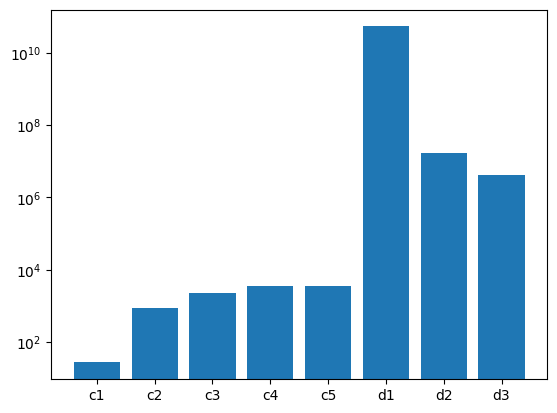

In [18]:
plt.bar(layers, layer_params)
ax = plt.gca()
ax.set_yscale('log')